# Qwen Image Edit Pipeline
本notebook用于运行Qwen图像编辑模型，支持加载LoRA权重进行推理

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:

import sys
import json
import torch
from PIL import Image
from safetensors.torch import load_file
from diffsynth.pipelines.qwen_image import QwenImagePipeline, ModelConfig
import matplotlib.pyplot as plt

def load_ste_and_lora(pipe, ckpt_path):
    """Load STE and LoRA weights into the pipeline."""
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Missing checkpoint: {ckpt_path}")
    
    print(f"Loading weights from {ckpt_path}...")
    state = load_file(str(ckpt_path), device="cpu")

    # Load STE (Spatial Temporal Encoder)
    ste_prefix = "pipe.ste."
    ste_state = {k[len(ste_prefix):]: v for k, v in state.items() if k.startswith(ste_prefix)}
    if ste_state:
        print(f"  - Loading {len(ste_state)} STE tensors")
        pipe.ste.load_state_dict(ste_state, strict=False)

    # Load LoRA
    lora_state = {k: v for k, v in state.items() if "lora_" in k}
    if lora_state:
        print(f"  - Loading {len(lora_state)} LoRA tensors")
        # Move LoRA weights to the correct device and dtype
        lora_state = {k: v.to(device=pipe.device, dtype=pipe.torch_dtype) for k, v in lora_state.items()}
        pipe.load_lora(pipe.dit, state_dict=lora_state)
    
    print("Checkpoint loaded successfully.")

def preprocess_image(image_pil, max_pixels=1048576):
    orig_width, orig_height = image_pil.size
    curr_pixels = orig_width * orig_height

    # Always resize to match max_pixels approx, whether scaling up or down
    factor = (max_pixels / curr_pixels) ** 0.5
    inter_width = int(orig_width * factor)
    inter_height = int(orig_height * factor)
    print(f"Scaling from {orig_width}x{orig_height} to {inter_width}x{inter_height}")
    image_pil = image_pil.resize((inter_width, inter_height), Image.LANCZOS)

    # Align to 16 pixels
    target_width = ((inter_width + 15) // 16) * 16
    target_height = ((inter_height + 15) // 16) * 16
    
    if target_width != inter_width or target_height != inter_height:
        print(f"Padding to {target_width}x{target_height}")
        new_image = Image.new("RGB", (target_width, target_height), (0, 0, 0))
        new_image.paste(image_pil, (0, 0))
        image_pil = new_image
    
    return image_pil, inter_width, inter_height, target_width, target_height

def load_edit_sessions(json_path):
    """Load edit sessions from JSON file"""
    with open(json_path, 'r') as f:
        return json.load(f)

print("✓ 函数已加载")

✓ 函数已加载


## 1. 加载模型和权重

In [3]:
# 配置参数
device = "cuda"  # 或 "cuda:0"
lora_path = "/host/ssd2/xiong-p/qwenpe/train/Qwen-Image-Edit-2509_lora-rank512-cfg/step-30000.safetensors"

# 初始化pipeline
print(f"Initializing Qwen Pipeline on {device}...")
pipe = QwenImagePipeline.from_pretrained(
    torch_dtype=torch.bfloat16,
    device=device,
    model_configs=[
        ModelConfig(model_id="Qwen/Qwen-Image-Edit-2509", origin_file_pattern="transformer/diffusion_pytorch_model*.safetensors"),
        ModelConfig(model_id="Qwen/Qwen-Image", origin_file_pattern="text_encoder/model*.safetensors"),
        ModelConfig(model_id="Qwen/Qwen-Image", origin_file_pattern="vae/diffusion_pytorch_model.safetensors"),
    ],
    processor_config=ModelConfig(model_id="Qwen/Qwen-Image-Edit", origin_file_pattern="processor/"),
)

# 加载STE和LoRA权重
load_ste_and_lora(pipe, lora_path)
print("✓ 模型加载完成")

Initializing Qwen Pipeline on cuda...


/host/ssd2/xiong-p/qwenpe/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Fetching 0 files: 0it [00:00, ?it/s]

Loading models from: [
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00005-of-00005.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00001-of-00005.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00003-of-00005.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00002-of-00005.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00004-of-00005.safetensors"
]
Loaded model: {
    "model_name": "qwen_image_dit",
    "model_class": "diffsynth.models.qwen_image_dit.QwenImageDiT",
    "extra_kwargs": null
}


Fetching 0 files: 0it [00:00, ?it/s]

Loading models from: [
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00004-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00003-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00002-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00001-of-00004.safetensors"
]
Loaded model: {
    "model_name": "qwen_image_text_encoder",
    "model_class": "diffsynth.models.qwen_image_text_encoder.QwenImageTextEncoder",
    "extra_kwargs": null
}


Fetching 0 files: 0it [00:00, ?it/s]

Loading models from: "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/vae/diffusion_pytorch_model.safetensors"
Loaded model: {
    "model_name": "qwen_image_vae",
    "model_class": "diffsynth.models.qwen_image_vae.QwenImageVAE",
    "extra_kwargs": null
}
Using qwen_image_text_encoder from [
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00004-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00003-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00002-of-00004.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image/text_encoder/model-00001-of-00004.safetensors"
].
Using qwen_image_dit from [
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/transformer/diffusion_pytorch_model-00005-of-00005.safetensors",
    "/home/yanai-lab/xiong-p/ssd/xiong-p/models/Qwen/Qwen-Image-Edit-2509/tran

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Loading weights from /host/ssd2/xiong-p/qwenpe/train/Qwen-Image-Edit-2509_lora-rank512-cfg/step-30000.safetensors...
  - Loading 900 STE tensors
  - Loading 1440 LoRA tensors
720 tensors are fused by LoRA. Fused LoRA layers cannot be cleared by `pipe.clear_lora()`.
Checkpoint loaded successfully.
✓ 模型加载完成


## 2. 加载图片并进行推理

In [11]:
# 选择session ID和编辑索引

session_id = "116518"  # 修改为你要处理的session ID
edit_index = 1  # 第几个编辑步骤（从0开始）

Session: 116518, Edit: 1
Input: test/images/116518/116518-output1.png
Mask: test/images/116518/116518-mask2.png
Prompt: Have the dog lick the teddy bear.

Loading and preprocessing images...
Scaling from 1024x1024 to 1024x1024

Prompt: Picture 1 is the image to modify. Have the dog lick the teddy bear.
Size: 1024x1024


100%|██████████| 50/50 [01:38<00:00,  1.98s/it]



Saving output to qwen_results/116518_edit1.png
Saved sub image to qwen_results/116518_edit1_sub.png


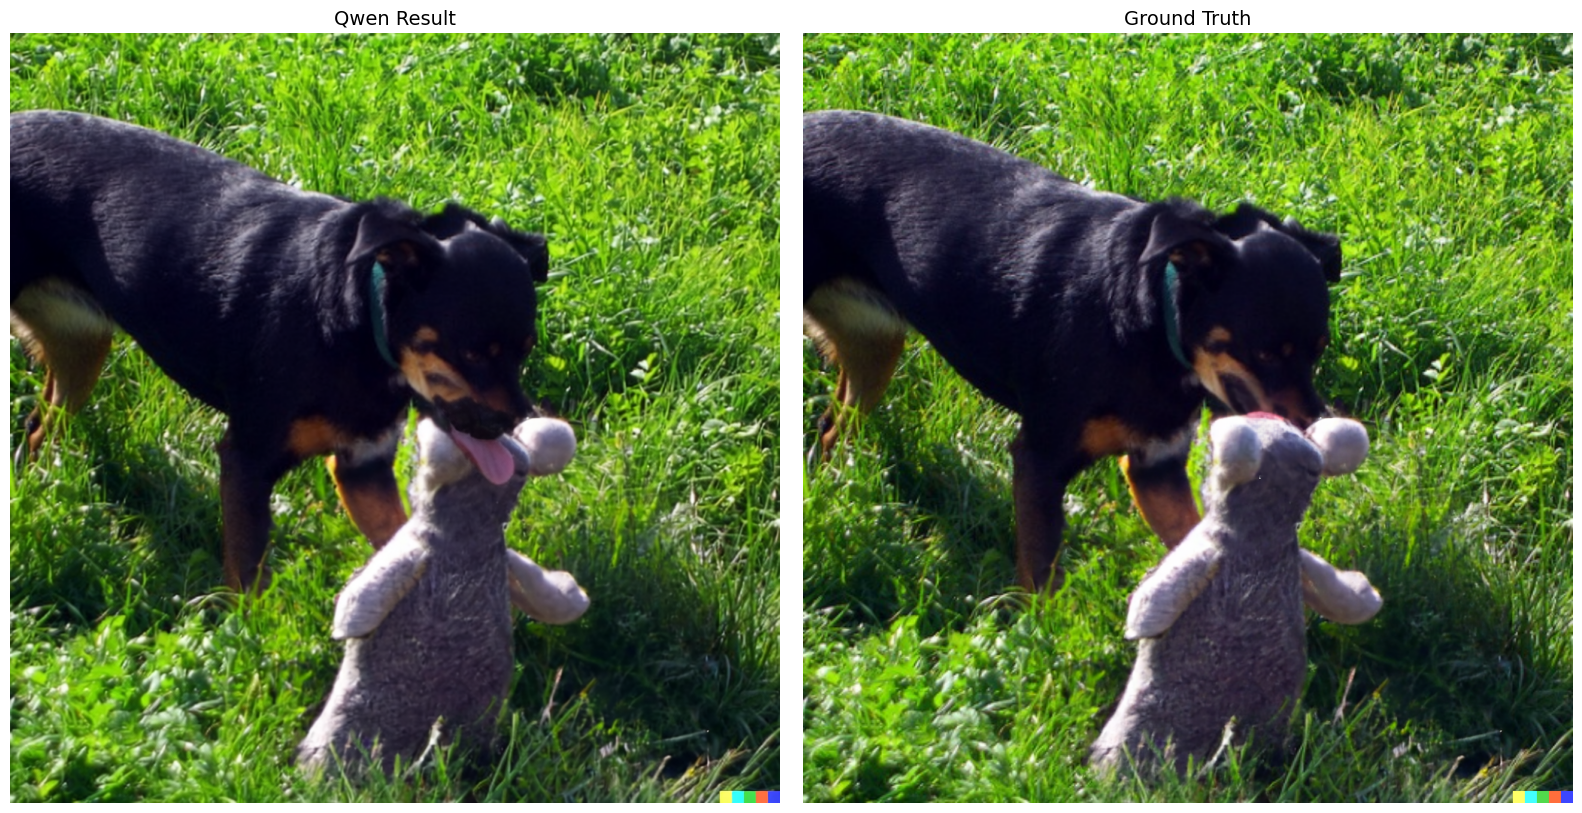

In [12]:
import matplotlib.pyplot as plt
# 从JSON配置文件读取
json_path = "test/edit_sessions.json"
images_base_dir = "test/images"

# 加载配置
edit_sessions = load_edit_sessions(json_path)


# 获取编辑任务
if session_id not in edit_sessions:
    raise ValueError(f"Session {session_id} not found in JSON")

edit_task = edit_sessions[session_id][edit_index]

# 构建图片路径
image_path = os.path.join(images_base_dir, session_id, edit_task["input"])
mask_path = os.path.join(images_base_dir, session_id, edit_task["mask"])
output_path = os.path.join("qwen_results", f"{session_id}_edit{edit_index}.png")
gt_path = os.path.join(images_base_dir, session_id, edit_task["output"])
prompt = edit_task["instruction"]

print(f"Session: {session_id}, Edit: {edit_index}")
print(f"Input: {image_path}")
print(f"Mask: {mask_path}")
print(f"Prompt: {prompt}")

# 推理参数
seed = 1
steps = 50
cfg_scale = 2.0
blend_alpha = 0.1
ref_image_path = None  # 可选的参考图片

# 加载和预处理图片
print("\nLoading and preprocessing images...")
image_pil = Image.open(image_path).convert("RGB")
image_pil, inter_width, inter_height, target_width, target_height = preprocess_image(image_pil)

# 处理mask
input_mask = Image.open(mask_path)
if input_mask.mode in ('RGBA', 'LA') or (input_mask.mode == 'P' and 'transparency' in input_mask.info):
    alpha = input_mask.convert('RGBA').split()[-1]
    if alpha.getextrema() != (255, 255):
        raw_mask = alpha.point(lambda p: 255 if p < 255 else 0).resize((inter_width, inter_height), Image.NEAREST)
    else:
        raw_mask = input_mask.convert("L").resize((inter_width, inter_height), Image.NEAREST)
else:
    raw_mask = input_mask.convert("L").resize((inter_width, inter_height), Image.NEAREST)

# Pad Mask
if target_width != inter_width or target_height != inter_height:
    back_mask = Image.new("L", (target_width, target_height), 0)
    back_mask.paste(raw_mask, (0, 0))
else:
    back_mask = raw_mask

# 加载GT图片（如果存在）
gt = None
if os.path.exists(gt_path):
    gt = Image.open(gt_path).convert("RGB")

# 准备edit_images列表
edit_images = [image_pil]
if ref_image_path:
    ref_img = Image.open(ref_image_path).convert("RGB")
    ref_processed, _, _, _, _ = preprocess_image(ref_img)
    edit_images.append(ref_processed)

# 执行推理
full_prompt = "Picture 1 is the image to modify. " + prompt
print(f"\nPrompt: {full_prompt}")
print(f"Size: {target_width}x{target_height}")

output_image, sub_image = pipe(
    prompt=full_prompt,
    edit_image=edit_images,
    edit_image_auto_resize=False,
    back_mask=back_mask,
    height=target_height,
    width=target_width,
    num_inference_steps=steps,
    cfg_scale=cfg_scale,
    seed=seed,
    inpaint_blend_alpha=blend_alpha,
)

# 保存结果
print(f"\nSaving output to {output_path}")
os.makedirs(os.path.dirname(output_path), exist_ok=True)
output_image.save(output_path)
if sub_image:
    sub_out = os.path.splitext(output_path)[0] + "_sub.png"
    sub_image.save(sub_out)
    print(f"Saved sub image to {sub_out}")

# 并排显示结果
if gt is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(output_image)
    axes[0].set_title('Qwen Result', fontsize=14)
    axes[0].axis('off')
    axes[1].imshow(gt)
    axes[1].set_title('Ground Truth', fontsize=14)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    display(output_image)